# paper

> This notebook contains used code that is used to generate data in the published version of the reproduce.work v0.0.1 working paper.

In [1]:
#| default_exp paper

In [2]:
#| hide
from nbdev.showdoc import *
%config InlineBackend.figure_formats = ['svg']

In [3]:
from reproduce_work import *

╔ω: Setting reproduce.work config dir to ./reproduce. Be sure to run generate_config() to generate a config file before
executing any other commands. Define `REPROWORKDIR` ENV variable with valid config to avoid this message.


In [4]:
register_notebook('03_paper.ipynb')

╔ω: Registered notebook https://github.com/reproduce-work/reproduce-work/blob/main/nbs/03_paper.ipynb in reproduce/config.toml


╔ω: Updated ['x', 'x'] in reproduce/pubdata.toml
╔ω: Updated ['y', 'y'] in reproduce/pubdata.toml
╔ω: Found embedded at second level: model_data.x: <reproduce_work.core.PublishedObj object at 0xffff7a207f10>
╔ω: Found embedded at second level: model_data.y: <reproduce_work.core.PublishedObj object at 0xffff61b2feb0>
╔ω: Updated ols_model_summary in reproduce/pubdata.toml


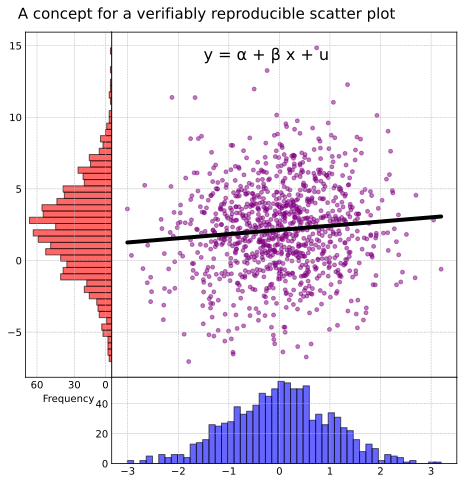

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm

random_state = np.random.RandomState(2353)

# 1. Generating Data
# Generate 1000 random samples from a standard normal distribution for x-axis
x = random_state.randn(1000)
# Generate 1000 random samples from a gamma distribution for y-axis
# We'll use shape=2 and scale=1 for the gamma distribution as an example.
y = random_state.gamma(2, 1, 1000)
# add noise
u, v = random_state.randn(1000), random_state.randn(1000)
y = y + 0.3*(x + u) + 3*v

x_obj = publish_data(x, 'x', metadata={'description': 'x-values for scatter plot'})
y_obj = publish_data(y, 'y', metadata={'description': 'y-values for scatter plot'})

#plt.style.use('seaborn-whitegrid')

# 2. Scatter Plot
# Create a main figure and axes
fig = plt.figure(figsize=(8, 8))
# Define the proportions of the scatter plot and histograms
scatter_ax = plt.axes([0.2, 0.2, 0.6, 0.6])  # [left, bottom, width, height]
x_hist_ax = plt.axes([0.2, 0.05, 0.6, 0.15], sharex=scatter_ax)
y_hist_ax = plt.axes([0.05, 0.2, 0.15, 0.6], sharey=scatter_ax)

# Plot the scatter plot
scatter_ax.scatter(x, y, alpha=0.5)
scatter_ax.set_xlabel('Normal Distribution')
scatter_ax.set_ylabel('Gamma Distribution')

# 3. Histograms
# Plot the histogram for x-values
x_hist_ax.hist(x, bins=50, edgecolor='k', alpha=0.6, color='blue', orientation='vertical')
x_hist_ax.set_ylabel(' ')
x_hist_ax.set_title(' ')
# Add ticks at 0, 30, 60 for the frequency axis
x_hist_ax.set_yticks([0, 20, 40])
x_hist_ax.set_yticklabels([0, 20, 40])

# Plot the rotated histogram for y-values
y_hist_ax.hist(y, bins=50, edgecolor='k', alpha=0.6, color='red', orientation='horizontal')
y_hist_ax.set_title(' ')

# Remove ticks from the histograms
x_hist_ax.xaxis.set_tick_params(which='both', size=0)
x_hist_ax.yaxis.set_tick_params(which='both', size=0)
y_hist_ax.xaxis.set_tick_params(which='both', size=0)
y_hist_ax.yaxis.set_tick_params(which='both', size=0)


# Adjustments to the previous visualization:

# 1. Flipping the y-data histogram so that left corresponds to higher frequencies.
y_hist_ax.clear()  # Clear the previous histogram
y_hist_ax.hist(y, bins=50, edgecolor='k', alpha=0.6, color='red', orientation='horizontal')
y_hist_ax.invert_xaxis()  # Invert the x-axis to achieve the desired flipping
y_hist_ax.set_xlabel('Frequency')

# 2. For the scatter plot, use circle markers with the color purple
scatter_ax.clear()  # Clear the previous scatter plot
scatter_ax.scatter(x, y, s=15, alpha=0.5, c='purple', marker='o')
scatter_ax.set_xlabel('Normal Distribution')
scatter_ax.set_ylabel('Gamma Distribution')



# compute slope and stats
# perform OLS regression
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
model_summary = (
    model
    .summary()
    .tables[1]
    .as_latex_tabular()
    .replace('\n', ' ')
    .replace('const', '$\\alpha$')
    .replace('x1', '$\\beta$')
)

model_pub_ojb = publish_data(
    model_summary, 'ols_model_summary',
    metadata={
        'description': 'OLS Model Summary from regression of y on x',
        'badge': 'reproduce-work-logo',
        'model_data': {
            'x': x_obj,
            'y': y_obj
        }
    }
)

# extract coefficients and p-values
alpha, beta = model.params
p_alpha, p_beta = model.pvalues
p_alpha_str = f'{p_alpha:.3f}'
p_beta_str = f'{p_beta:.3f}'

scatter_ax.plot(x, alpha + beta*x, color='black', lw=4)


# Add ticks at 0, 30, 60 for the frequency axis
y_hist_ax.set_xticks([5, 30, 60])
y_hist_ax.set_xticklabels([0, 30, 60])

# Set a white background with grid
for ax in [scatter_ax, x_hist_ax, y_hist_ax]:
    ax.set_facecolor('white')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)


# add p-value and slope to plot
# alpha
scatter_ax.text(x=-1.5, y=14, s='y = α + β x + u', size=16)

# Add the SVG to the plot in the bottom right corner

plt.title('A concept for a verifiably reproducible scatter plot', size=15, pad=10, x=2.1, y=1.01)
# Display the updated plot
plt.show()


In [6]:
# save the figure
fig.savefig('img/scatter_plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [7]:
scatter_obj = publish_file('img/scatter_plot.pdf', metadata={
    'plot': True,
    'description': 'Scatter plot with OLS model line from regression of y on x',
    'badge': 'reproduce-work-logo',
    'plot_data': {
        'x': x_obj.metadata['published_url'],
        # can automatically render published objects to be cross-referenced in the metadata
        'y': y_obj, # <-- is of PublishedObj type; gets rendered as y_obj.metadata['published_url']
        'alpha': alpha,
        'beta': beta,
        'p_alpha': p_alpha,
        'p_beta': p_beta
    }
})

╔ω: Found embedded at second level: plot_data.y: <reproduce_work.core.PublishedObj object at 0xffff61b2feb0>


<IPython.core.display.Javascript object>

╔ω: Updated watched files to ['document/main.md', 'reproduce/pubdata.toml', 'document/latex/template.tex', 'document/latex/bibliography.bib', 'nbs/00_introduction.ipynb', 'img/reproducible_plot.svg', 'nbs/01_core.ipynb', 'nbs/03_paper.ipynb', 'img/scatter_plot.pdf']
{'p_value_str': {'description': 'The p-value of the coefficient on the slope of the linear regression line.', 'published_url': 'https://github.com/reproduce-work/reproduce-work/blob/main/reproduce/pubdata.toml', 'generating_script': 'https://github.com/reproduce-work/reproduce-work/blob/main/nbs/00_introduction.ipynb', 'timestamp': '2023-10-10T08:06:57.459761', 'content_hash': 'd68a5a88e3ca0ee94ee5951c43fbb552', 'timed_hash': '86357bb9e2a7e398c75c2e01ef00ff67', 'python_version': '3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:23:23)  [GCC 10.3.0]', 'platform_info': 'Linux-6.4.16-orbstack-00105-g14094bfeec09-aarch64-with-glibc2.35', 'value': '0.068'}, 'x': {'description': 'x-values for scatter plot', 'published_ur

In [8]:
#| hide
import nbdev; nbdev.nbdev_export()